# SOMS Q Fluxes, pCO2sw decomp

In [1]:
import sys
import numpy as np
import scipy as sp
import netCDF4 as nc4
import matplotlib.pyplot as plt
import xarray as xr
import dask.array as da
import pandas as pd
#from glob import glob
import glob

import numpy.linalg as linalg
import scipy.signal as signal
import scipy.ndimage as ndimage
import scipy.interpolate as interpolate

from netCDF4 import Dataset

from itertools import repeat

# import sys
# sys.path.insert(0, '/home/tsmith/scratch/eddyTracking/ecjoliver/')
# import params 

import re

from scipy.io.netcdf import netcdf_file as netcdf
import cmocean.cm as cmo
import warnings
import matplotlib.colors as colors
from cartopy import crs as ccrs, feature as cfeature

# import copy
# sys.path.insert(0, '/home/tsmith/scratch/SOMS_equal/')
# from SOMS_code import *
# from RegridderPLUS import *

In [2]:
import datetime
import netCDF4

In [3]:
%matplotlib inline

In [4]:
def find_ind(grid1d, coord):
        a=abs(grid1d-coord)
        return np.where(a==np.min(a))[0][0]

## Load Dataset

In [5]:
grid_CYC = xr.open_mfdataset('/home/tsmith/scratch/Anomalies_NEW/SOMS_Dataset_Cyclonic.nc')
grid_ACYC = xr.open_mfdataset('/home/tsmith/scratch/Anomalies_NEW/SOMS_Dataset_Anticyclonic.nc')

In [6]:
QnetC = grid_CYC['Qnet']
QswC = grid_CYC['Qsw']
QlwC = grid_CYC['Qlw']
QsC = grid_CYC['Qs']
QlC = grid_CYC['Ql']

In [7]:
QnetA = grid_ACYC['Qnet']
QswA = grid_ACYC['Qsw']
QlwA = grid_ACYC['Qlw']
QsA = grid_ACYC['Qs']
QlA = grid_ACYC['Ql']

In [8]:
radC = grid_CYC['Radius']
radA = grid_ACYC['Radius']

In [9]:
radC_array = radC.values
radA_array = radA.values


In [10]:
#SOM Map Config
xdim=3
ydim=3
n=xdim*ydim

In [11]:
## LIMITS

lim_spec = np.arange(-352.5,353,7.5)

lim = find_ind(lim_spec,240)-47

lim_specC = lim_spec[47-lim:48+lim]

In [12]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

## Figure 8: Q Fluxes over eddy

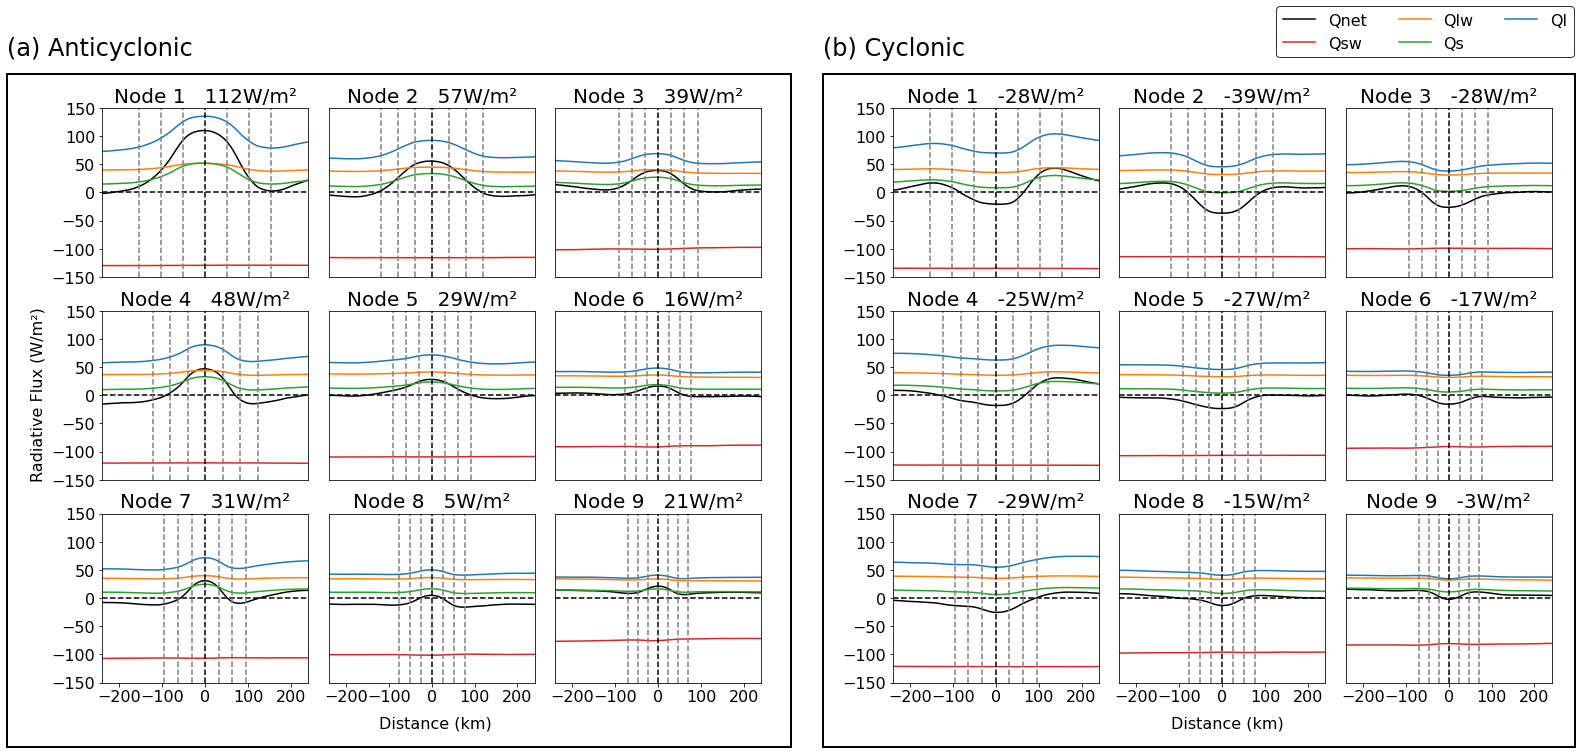

In [13]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(22, 10.5),facecolor='w')
outer_grid = GridSpec(1, 2, width_ratios=[1, 1])

angle = np.linspace(0,2*np.pi,150)

# First grid
i = 0
inner_grid = GridSpecFromSubplotSpec(3, 3, subplot_spec=outer_grid[i], wspace=0.1, hspace=0.2)
for k in range(9):
    row, col = divmod(k, 3)
    ax = fig.add_subplot(inner_grid[row, col])
    
    net = ax.plot(lim_specC, -QnetA[k,47,47-lim:47+lim+1],color='k',label='Qnet')
    sw = ax.plot(lim_specC, -QswA[k,47,47-lim:47+lim+1],color='tab:red',label='Qsw')
    lw = ax.plot(lim_specC, -QlwA[k,47,47-lim:47+lim+1],color='tab:orange',label='Qlw')
    s = ax.plot(lim_specC, -QsA[k,47,47-lim:47+lim+1],color='tab:green',label='Qs')
    l = ax.plot(lim_specC, -QlA[k,47,47-lim:47+lim+1],color='tab:blue',label='Ql')
    
#     ax1 = ax.twinx()
#     ax1.plot(lim_specC,FCO2A[k,47,47-lim:48+lim]*(-86400000),color='tab:grey')
    
#     ax1.set_ylim(-10,10)
#     ax1.set_yticks([-10,-5,0] if col == 2 else [])
    
        #centre
    ax.axvline(x=0,color='k',linestyle='--')
    ax.axhline(y=0,color='k',linestyle='--')
    #1xr
    ax.axvline(x=-radC_array[k],color='grey',linestyle='--')
    ax.axvline(x=radC_array[k],color='grey',linestyle='--')
    #2r
    ax.axvline(x=-2*(radC_array[k]),color='grey',linestyle='--')
    ax.axvline(x=2*(radC_array[k]),color='grey',linestyle='--')
    #3r
    ax.axvline(x=-3*(radC_array[k]),color='grey',linestyle='--')
    ax.axvline(x=3*(radC_array[k]),color='grey',linestyle='--')
    
    ax.set_yticks([-150,-100,-50,0,50,100,150] if col == 0 else [])
    ax.set_xticks([-200,-100,0,100,200]  if row == 2 else [])
    #can specify left or right justification but easier to just add spaces inbetween
    ax.set_title("Node %i   %dW/m\u00b2" % (k+1, np.max(-QnetA[k,47-lim:48+lim,47-lim:48+lim])),fontsize=20)
    ax.set_xlim(-240,240)
    ax.set_ylim(-150,150)
    
    #ax.set_title("Node {:<2d}{:>10.2f}°C".format(k+1, float(RV_arrayA[k,0,:,:].max(('y','x')))))
    
    fig.add_subplot(ax)

# Draw black box around the subplots in the first grid
# rect = Rectangle((0.005, 0.005), 0.48, 0.9, fill=False, lw=2, edgecolor='black', transform=fig.transFigure)
# fig.add_artist(rect)

rect = Rectangle((0.005, 0.005), 0.495, 0.89, fill=False, lw=2, edgecolor='black', transform=fig.transFigure)
fig.add_artist(rect)

# Second grid
i = 1
inner_grid = GridSpecFromSubplotSpec(3, 3, subplot_spec=outer_grid[i], wspace=0.1, hspace=0.2)
for k in range(9):
    row, col = divmod(k, 3)
    ax = fig.add_subplot(inner_grid[row, col])
    net = ax.plot(lim_specC, -QnetC[k,47,47-lim:47+lim+1],color='k',label='Qnet')
    sw = ax.plot(lim_specC, -QswC[k,47,47-lim:47+lim+1],color='tab:red',label='Qsw')
    lw = ax.plot(lim_specC, -QlwC[k,47,47-lim:47+lim+1],color='tab:orange',label='Qlw')
    s = ax.plot(lim_specC, -QsC[k,47,47-lim:47+lim+1],color='tab:green',label='Qs')
    l = ax.plot(lim_specC, -QlC[k,47,47-lim:47+lim+1],color='tab:blue',label='Ql')
    
#     ax1 = ax.twinx()
#     ax1.plot(lim_specC,FCO2C[k,47,47-lim:48+lim]*(-86400000),color='tab:grey',label='FCO2')
    
#     ax1.set_ylim(-10,10)
#     ax1.set_yticks([-10,-5,0] if col == 2 else [])
    
            #centre
    ax.axvline(x=0,color='k',linestyle='--')
    ax.axhline(y=0,color='k',linestyle='--')
    #1xr
    ax.axvline(x=-radC_array[k],color='grey',linestyle='--')
    ax.axvline(x=radC_array[k],color='grey',linestyle='--')
    #2r
    ax.axvline(x=-2*(radC_array[k]),color='grey',linestyle='--')
    ax.axvline(x=2*(radC_array[k]),color='grey',linestyle='--')
    #3r
    ax.axvline(x=-3*(radC_array[k]),color='grey',linestyle='--')
    ax.axvline(x=3*(radC_array[k]),color='grey',linestyle='--')
    
    ax.set_yticks([-150,-100,-50,0,50,100,150] if col == 0 else [])
    ax.set_xticks([-200,-100,0,100,200]  if row == 2 else [])
    ax.set_title("Node %i   %dW/m\u00b2" % (k+1, np.min(-QnetC[k,47-lim:48+lim,47-lim:48+lim])),fontsize=20)
    
    ax.set_ylim(-150,150)
    ax.set_xlim(-240,240)
    
    fig.add_subplot(ax)

# Draw black box around the subplots in the second grid
# rect = Rectangle((0.52, 0.005), 0.475, 0.9, fill=False, lw=2, edgecolor='black', transform=fig.transFigure)
# fig.add_artist(rect)

rect = Rectangle((0.52, 0.005), 0.475, 0.89, fill=False, lw=2, edgecolor='black', transform=fig.transFigure)
fig.add_artist(rect)

# # Add colorbar
# cbar_ax = fig.add_subplot(outer_grid[2])
# cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='vertical',
#                     #label='Temp anomaly °C',
#                     shrink=1,aspect=20)
# cbar.set_ticks([0,1,2,3,4,5])
# cbar.ax.tick_params(labelsize=16)
# cbar_ax.set_title('Node\nPercentage\n(%)',pad=10,fontsize=18)
# #cbar.set_label('Temp anomaly °C', rotation=90, labelpad=10, fontsize=16)

# Adjust layout
fig.tight_layout()
# plt.subplots_adjust(wspace=0.25)
# plt.subplots_adjust(left=0.06)
# plt.subplots_adjust(right=0.95)
# plt.subplots_adjust(top=0.85)

plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(left=0.065)
plt.subplots_adjust(right=0.98)
plt.subplots_adjust(bottom=0.09)

# #plt.subplots_adjust(wspace=0.25)
# #plt.subplots_adjust(right=0.85)
# # plt.subplots_adjust(top=0.85)
#plt.subplots_adjust(left=0.1)

#cbar_ax.set_position([0.5,0.5,0.5,0.9])

#plt.subplots_adjust(right=0.85)

# Add labels
fig.text(0.005, 0.92, '(a) Anticyclonic', fontsize=24, fontweight='normal')
fig.text(0.52, 0.92, '(b) Cyclonic', fontsize=24, fontweight='normal')
fig.text(0.02,0.36, 'Radiative Flux (W/m\u00B2)',rotation='vertical',fontsize=16)

fig.text(0.24, 0.03, 'Distance (km)', fontsize=16, fontweight='normal')
fig.text(0.74, 0.03, 'Distance (km)', fontsize=16, fontweight='normal')

#fig.text(0.98,0.35, 'FCO2 (mmolC/m\u00B2/day)',rotation='vertical',fontsize=16)
# fig.text(0.215,0.03, 'Longitude (°)',rotation='horizontal',fontsize=16)
# fig.text(0.67,0.03, 'Longitude (°)',rotation='horizontal',fontsize=16)

handles, labels = ax.get_legend_handles_labels()
# handles1, labels1 = ax1.get_legend_handles_labels()
# handles += handles1
# labels += labels1
fig.legend(handles, labels,loc='upper right', bbox_to_anchor=(0.999, 0.995),ncol=3,fontsize=16,edgecolor='k')

# frame = legend.get_frame()
# frame.set_edgecolor('k')

#plt.savefig('/home/tsmith/scratch/images/Paper1/Qnet_Figure11_NEW.png', dpi=500)

## Load CO2 variables

In [14]:
pCO2sw_C = grid_CYC['pCO2sw']
pCO2sw_anomC = grid_CYC['pCO2sw_anomaly']
dpCO2_C = grid_CYC['dpCO2']
FCO2_C = grid_CYC['FCO2']
SST_anomC = grid_CYC['Temperature_anomaly'][:,0]

In [15]:
pCO2sw_A = grid_ACYC['pCO2sw']
pCO2sw_anomA = grid_ACYC['pCO2sw_anomaly']
dpCO2_A = grid_ACYC['dpCO2']
FCO2_A = grid_ACYC['FCO2']
SST_anomA = grid_ACYC['Temperature_anomaly'][:,0]

## Decomposition

### Thermal component:
$$
(\frac{\partial pCO2}{\partial t})_{SST} = pCO2_{sw}\times 0.0423\times(\frac{\partial SST}{\partial t})
$$

In [ ]:
#pCO2sw is the average pCO2sw: SOMS_pCO2sw
#dSST/dt is the temperature anomaly: SOMS_SST_anom (node avg)

In [16]:
dpCO2_dt_THERM_A = pCO2sw_A*0.0423*SST_anomA
dpCO2_dt_THERM_C = pCO2sw_C*0.0423*SST_anomC

pCO2_THERM_A = pCO2sw_A*(np.exp(0.0423*(SST_anomA)))
pCO2_THERM_C = pCO2sw_C*(np.exp(0.0423*(SST_anomC)))

### Non-Thermal component:
$$
(\frac{\partial pCO2}{\partial t})_{NON-THERM} = (\frac{\partial pCO2sw}{\partial t}) - (\frac{\partial pCO2}{\partial t})_{SST}
$$

In [ ]:
#dpCO2sw/dt is the pCO2sw anomaly: SOMS_pCO2sw_anom
#(dpCO2/dt) is thermal component: dpCO2_dt_THERM 

In [17]:
dpCO2_dt_NON_THERM_A = pCO2sw_anomA-dpCO2_dt_THERM_A
dpCO2_dt_NON_THERM_C = pCO2sw_anomC-dpCO2_dt_THERM_C

In [19]:
lim_spec = np.arange(-352.5,353,7.5)

x_dist = np.empty(shape=(95,95))
y_dist = np.empty(shape=(95,95))

for i in range(95):
    #every row
    x_dist[i] = lim_spec
    #every col
    y_dist[:,i] = lim_spec


dist_matrix = np.empty(shape=(95,95))
for i in range(95):
    for j in range(95):
        dist = np.sqrt(x_dist[i,j]**2+y_dist[i,j]**2)
        dist_matrix[i,j] = dist

In [20]:
dist_maskA = np.empty(shape=(9,95,95))
for k in range(9):
    dist = 2*radA_array[k]
    dist_maskA[k] = np.where(dist_matrix>dist,np.nan,1)

dist_maskC = np.empty(shape=(9,95,95))
for k in range(9):
    dist = 2*radC_array[k]
    dist_maskC[k] = np.where(dist_matrix>dist,np.nan,1)

FCO2_maskA = FCO2_A*dist_maskA
FCO2_maskC = FCO2_C*dist_maskC

## Figure 9 pCO2sw decomposition

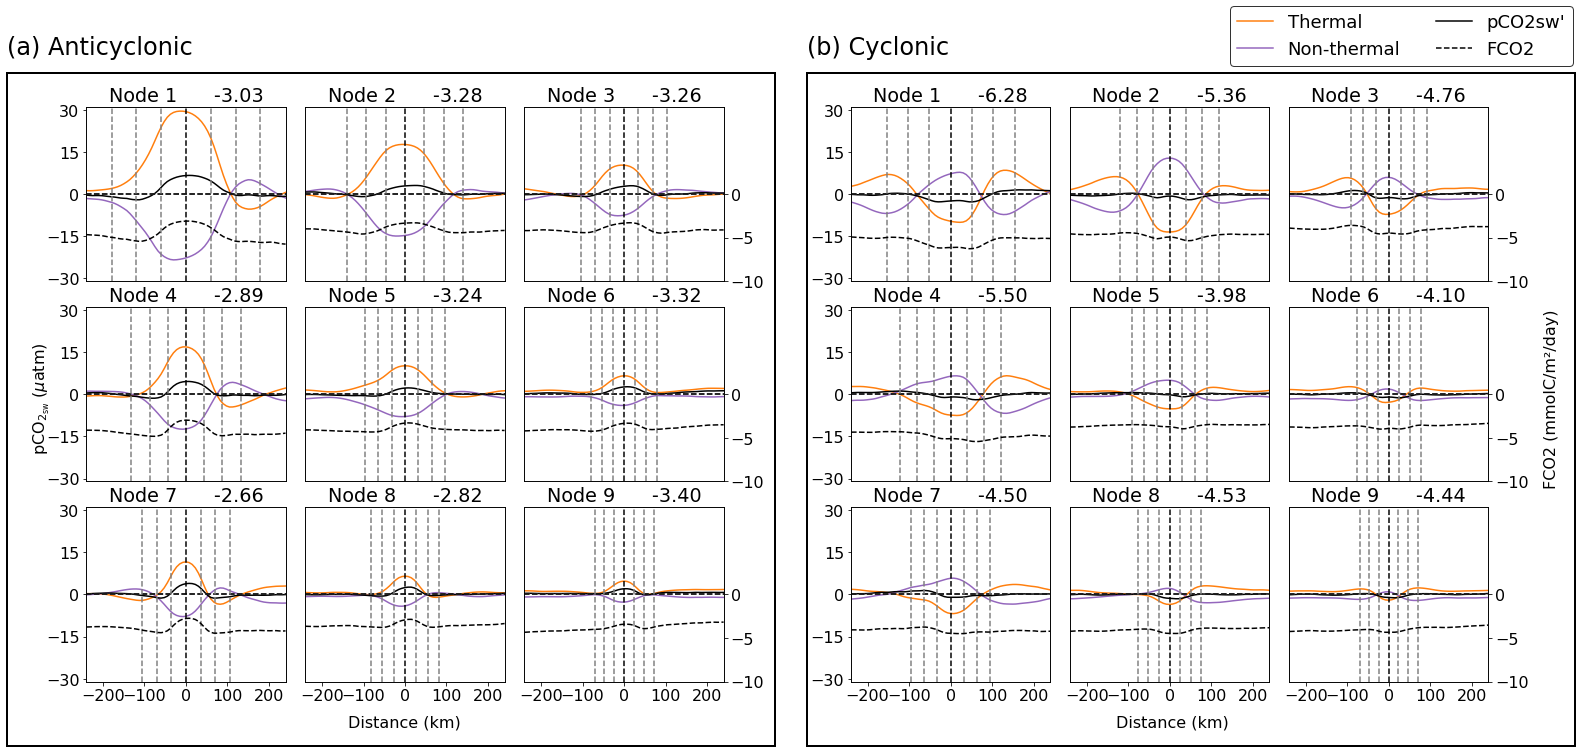

In [21]:
plt.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(22, 10.5),facecolor='w')
outer_grid = GridSpec(1, 2, width_ratios=[1, 1])

angle = np.linspace(0,2*np.pi,150)

# First grid
i = 0
inner_grid = GridSpecFromSubplotSpec(3, 3, subplot_spec=outer_grid[i], wspace=0.1, hspace=0.15)
for k in range(9):
    row, col = divmod(k, 3)
    ax = fig.add_subplot(inner_grid[row, col])
    
    ax.plot(lim_specC,dpCO2_dt_THERM_A[k,47,47-lim:48+lim],color='tab:orange',label='Thermal')
    ax.plot(lim_specC,dpCO2_dt_NON_THERM_A[k,47,47-lim:48+lim],color='tab:purple',label='Non-thermal')
    ax.plot(lim_specC,dpCO2_dt_THERM_A[k,47,47-lim:48+lim]+dpCO2_dt_NON_THERM_A[k,47,47-lim:48+lim],color='k',label='pCO2sw anom')
    ax.axhline(y=0,color='tab:grey',linestyle='--')

    #ax.plot(lim_specC,-SOMS_dpCO2A[k,47,47-lim:48+lim],color='tab:grey',label='dpCO2')
    
    ax.set_yticks([-30,-15,0,15,30] if col == 0 else [])
    ax.set_xticks([-200,-100,0,100,200] if row == 2 else [])

    ax1 = ax.twinx()
    ax1.plot(lim_specC,FCO2_A[k,47,47-lim:48+lim]*(-86400000),color='k',linestyle='--')
    
    ax1.set_ylim(-10,10)
    ax1.set_yticks([-10,-5,0] if col == 2 else []) 

    
    #centre
    ax.axvline(x=0,color='k',linestyle='--')
    ax.axhline(y=0,color='k',linestyle='--')
    #1xr
    ax.axvline(x=-radA_array[k],color='grey',linestyle='--')
    ax.axvline(x=radA_array[k],color='grey',linestyle='--')
    #2r
    ax.axvline(x=-2*(radA_array[k]),color='grey',linestyle='--')
    ax.axvline(x=2*(radA_array[k]),color='grey',linestyle='--')
    #3r
    ax.axvline(x=-3*(radA_array[k]),color='grey',linestyle='--')
    ax.axvline(x=3*(radA_array[k]),color='grey',linestyle='--')
    

    #ax[k].set_extent([-10.75,20.5,-53.4,-37.56])
    #ax[k].coastlines()    
    #ptitle = str(Months[k])
    ax.set_title("Node %i      " %(k+1) + "%.2f"  %(FCO2_maskA[k]*(-86400000)).max(('y','x')) )
    ax.set_ylim(-31,31)
    #ax1.set_ylim(-35,35)
    ax.set_xlim(-240,240)
    
    fig.add_subplot(ax)

rect = Rectangle((0.005, 0.005), 0.485, 0.89, fill=False, lw=2, edgecolor='black', transform=fig.transFigure)
fig.add_artist(rect)

# Second grid
i = 1
inner_grid = GridSpecFromSubplotSpec(3, 3, subplot_spec=outer_grid[i], wspace=0.1, hspace=0.15)
for k in range(9):
    row, col = divmod(k, 3)
    ax = fig.add_subplot(inner_grid[row, col])
    
    ax.plot(lim_specC,dpCO2_dt_THERM_C[k,47,47-lim:48+lim],color='tab:orange',label='Thermal')
    ax.plot(lim_specC,dpCO2_dt_NON_THERM_C[k,47,47-lim:48+lim],color='tab:purple',label='Non-thermal')
    ax.plot(lim_specC,dpCO2_dt_THERM_C[k,47,47-lim:48+lim]+dpCO2_dt_NON_THERM_C[k,47,47-lim:48+lim],color='k',label="pCO2sw'")
    ax.axhline(y=0,color='tab:grey',linestyle='--')

    #ax.plot(lim_specC,-SOMS_dpCO2C[k,47,47-lim:48+lim],color='tab:grey',label='dpCO2')
    
    ax.set_yticks([-30,-15,0,15,30] if col == 0 else [])
    ax.set_xticks([-200,-100,0,100,200] if row == 2 else [])
    
    ax1 = ax.twinx()
    ax1.plot(lim_specC,FCO2_C[k,47,47-lim:48+lim]*(-86400000),color='k',linestyle='--',label='FCO2')
    
    ax1.set_ylim(-10,10)
    ax1.set_yticks([-10,-5,0] if col == 2 else [])
    
    #centre
    ax.axvline(x=0,color='k',linestyle='--')
    ax.axhline(y=0,color='k',linestyle='--')
    #1xr
    ax.axvline(x=-radC_array[k],color='grey',linestyle='--')
    ax.axvline(x=radC_array[k],color='grey',linestyle='--')
    #2r
    ax.axvline(x=-2*(radC_array[k]),color='grey',linestyle='--')
    ax.axvline(x=2*(radC_array[k]),color='grey',linestyle='--')
    #3r
    ax.axvline(x=-3*(radC_array[k]),color='grey',linestyle='--')
    ax.axvline(x=3*(radC_array[k]),color='grey',linestyle='--')
    

    #ax[k].set_extent([-10.75,20.5,-53.4,-37.56])
    #ax[k].coastlines()    
    #ptitle = str(Months[k])
    ax.set_title("Node %i      " %(k+1) + "%.2f"  %(FCO2_maskC[k]*(-86400000)).min(('y','x')) )
    ax.set_ylim(-31,31)
    #ax1.set_ylim(-35,35)
    ax.set_xlim(-240,240)
    
    fig.add_subplot(ax)

# Draw black box around the subplots in the second grid
rect = Rectangle((0.51, 0.005), 0.485, 0.89, fill=False, lw=2, edgecolor='black', transform=fig.transFigure)
fig.add_artist(rect)


# Add colorbar
# cbar_ax = fig.add_subplot(outer_grid[2])
# cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='vertical',label='Temp anomaly °C',shrink=1,aspect=20)
# cbar.set_ticks([-0.1, -0.05, 0, 0.05, 0.1])
# cbar.ax.tick_params(labelsize=12)

# Adjust layout
fig.tight_layout()
plt.subplots_adjust(wspace=0.15)
#plt.subplots_adjust(right=0.85)

# Add labels
fig.text(0.005, 0.92, '(a) Anticyclonic', fontsize=24, fontweight='normal')
fig.text(0.51, 0.92, '(b) Cyclonic', fontsize=24, fontweight='normal')
fig.text(0.02,0.4, r'pCO$_{2_\mathrm{sw}}$ ($\mu$atm)',rotation='vertical')
fig.text(0.975,0.35, 'FCO2 (mmolC/m\u00B2/day)',rotation='vertical',fontsize=16)

fig.text(0.22, 0.03, 'Distance (km)', fontsize=16, fontweight='normal')
fig.text(0.705, 0.03, 'Distance (km)', fontsize=16, fontweight='normal')

# plt.subplots_adjust(wspace=0.25)
# plt.subplots_adjust(left=0.06)
# plt.subplots_adjust(right=0.95)
# plt.subplots_adjust(top=0.85)

plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(top=0.85)
plt.subplots_adjust(left=0.055)
plt.subplots_adjust(right=0.94)
plt.subplots_adjust(bottom=0.09)

handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax1.get_legend_handles_labels()
handles += handles1
labels += labels1

leg = fig.legend(handles, labels,loc='upper right', bbox_to_anchor=(0.999, 0.995),ncol=2,edgecolor='k',fontsize=18)
leg.get_frame().set_edgecolor('k')

#plt.savefig('/home/tsmith/scratch/images/Paper1/pCO2sw_decomp_detrend_Figure12_NEW.png', dpi=500)
